In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('q1.csv')
df.drop('country-year', axis=1, inplace=True)

In [4]:
# getting top 6 most populated countries
df_new = df.groupby(['country', 'year'], as_index=False).sum()
df_new = df_new.sort_values('population', ascending=False, ignore_index=True)
countries = df_new['country'].unique()

In [5]:
def intersection(lst1, lst2):  
    temp = set(lst2) 
    lst3 = [value for value in lst1 if value in temp] 
    return lst3

In [6]:
top_countries=[]
years=list(range(1000, 2050))
for c in countries:
    length = df_new.loc[df_new["country"]==c].shape[0]
    if length> 25:
        top_countries.append(c)
        years = intersection(years, df_new.loc[df_new["country"]==c]["year"].unique())
    if len(top_countries)==6:
        break
print(top_countries)
print(years)

['United States', 'Brazil', 'Russian Federation', 'Japan', 'Mexico', 'Germany']
[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]


In [7]:
df_new = df.loc[df["country"].isin(top_countries)]
df_new = df_new.loc[df_new["year"].isin(years)]
# the above lines have been suggested by a friend
df_new = df_new.groupby(["country", "year"], as_index=False).sum()
df_new["tot_sui_per_100k"] = (df_new["suicides_no"]/df_new["population"]) * (10**5)

In [8]:
print("Country Mean Variance")
for c in top_countries:
    print(c, round(df_new[df_new["country"]==c]["tot_sui_per_100k"].mean(), 3),
       round(df_new[df_new["country"]==c]["tot_sui_per_100k"].var(), 3))

Country Mean Variance
United States 12.711 0.877
Brazil 4.757 0.364
Russian Federation 32.884 64.299
Japan 22.189 11.859
Mexico 4.127 0.618
Germany 14.406 3.976


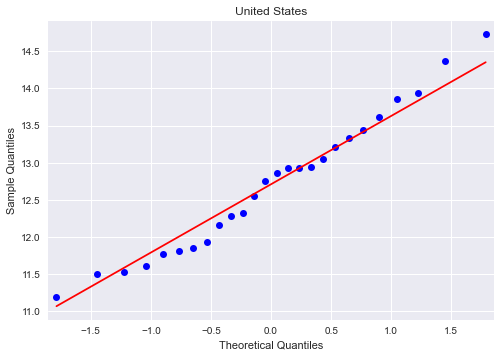

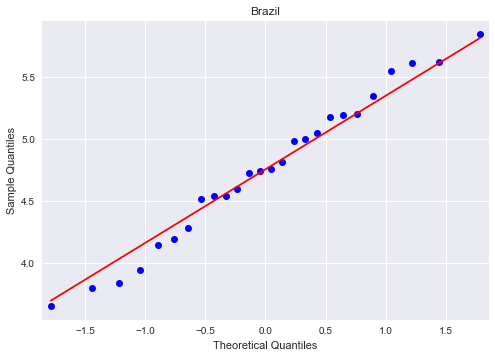

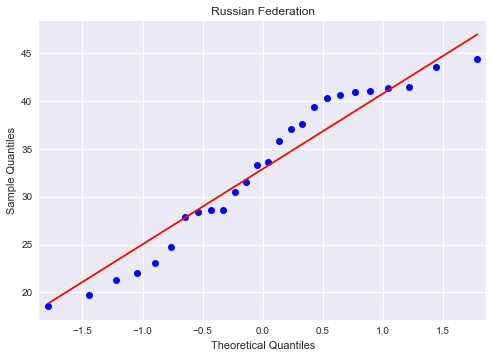

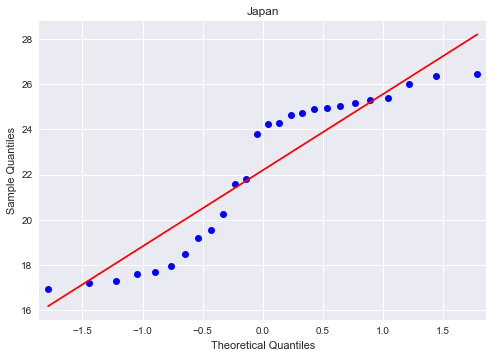

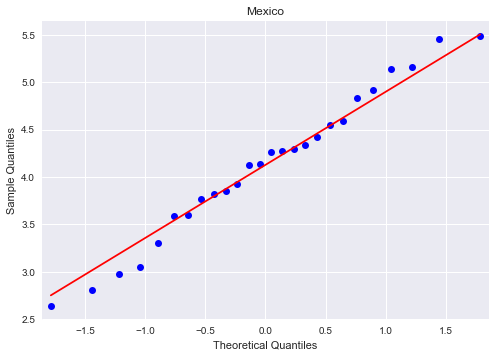

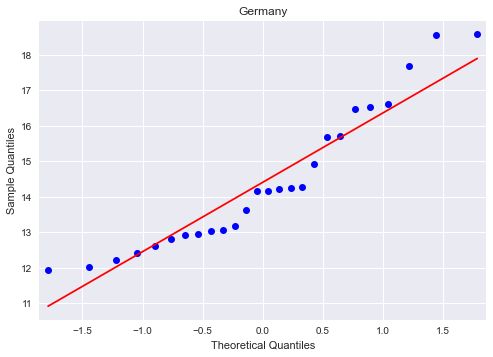

In [9]:
#displaying suicides for each year separately
from scipy.stats import gamma
import statsmodels.api as sm 
plt.style.use("seaborn")

for c in top_countries:
    sm.qqplot(data=df_new[df_new["country"]==c]["tot_sui_per_100k"], line='s')
    plt.title(c)
    plt.show()

In [10]:
def ll_wrt_norm(x, mu, sigma):
    normalization = 1/(((2*np.pi)**0.5)*sigma)
    p = (-((x-mu)**2)/(2*sigma**2))
    return np.log(normalization) + p
def ll_for_whole(vals, mu, sigma):
    in_lls = ll_wrt_norm(vals, mu, sigma)
    return np.sum(in_lls)

In [11]:
print("Log likelihoods of tot_sui_per_100k wrt normal distribution: ")

for c in top_countries:
    cnt = 1
    mu = df_new[df_new["country"]==c]["tot_sui_per_100k"].mean()
    sigma = df_new[df_new["country"]==c]["tot_sui_per_100k"].var()**0.5
    ans = ll_for_whole(df_new[df_new["country"]==c]["tot_sui_per_100k"], mu, sigma)
    print(c,round(ans, 3))

Log likelihoods of tot_sui_per_100k wrt normal distribution: 
United States -34.689
Brazil -23.246
Russian Federation -90.519
Japan -68.543
Mexico -30.13
Germany -54.337


The closer the points lie to the line,  the higher the log likelihood. i.e. If the straight line fits well, the likelihood is higher

In [12]:
import scipy.stats as stats

print("95% CI - Z interval, T interval : ")
for c in top_countries:
    mu = df_new[df_new["country"]==c]["tot_sui_per_100k"].mean()
    sigma = np.sqrt(df_new[df_new["country"]==c]["tot_sui_per_100k"].var())
    tot = len(list(df_new[df_new["country"]==c]["year"]))
    z_lower = mu - stats.norm.ppf(0.975)*(sigma/(np.sqrt(tot)))
    z_upper = mu + stats.norm.ppf(0.975)*(sigma/(np.sqrt(tot)))
    z_interval = (round(z_lower, 3), round(z_upper, 3))
    tot_sui = df_new[df_new["country"]==c]["tot_sui_per_100k"]
    t_interval = stats.t.interval(0.95, len(tot_sui)-1, scale=stats.sem(tot_sui), loc=np.mean(tot_sui))
    t_interval = (round(t_interval[0], 3), round(t_interval[1], 3))
    print(c, z_interval, t_interval)

95% CI - Z interval, T interval : 
United States (12.351, 13.071) (12.333, 13.09)
Brazil (4.525, 4.989) (4.513, 5.0)
Russian Federation (29.801, 35.966) (29.645, 36.123)
Japan (20.865, 23.512) (20.798, 23.58)
Mexico (3.825, 4.429) (3.809, 4.444)
Germany (13.639, 15.172) (13.6, 15.211)


In [13]:
# Closest means are US and Germany
c1="United States"
c2="Germany"
d1=df_new[df_new["country"]==c1]["tot_sui_per_100k"]
d2=df_new[df_new["country"]==c2]["tot_sui_per_100k"]
mu1 = d1.mean()
mu2 = d2.mean()
var1 = d1.var()
var2 = d2.var()
n1 = d1.shape[0]
n2 = d2.shape[0]
t = (mu1 - mu2) / np.sqrt((var1/n1) + (var2/n2))

#compute degrees of freedom (this, as well as wilcoxon, was suggested by a friend)
DoF = np.square((var1/n1) + (var2/n2)) / (((var1/n1)**2)/(n1-1) + ((var2/n2)**2)/(n2-1))

#compare values
threshold=0.05
critical_val = stats.t.pdf((1-threshold)/2,DoF)
print(np.abs(t), critical_val)
if np.abs(t) > critical_val:
    print('Null hypothesis is rejected')
    print('YES')
else:
    print('Null hypothesis is not rejected')
    print('NO')

3.9219085632057733 0.3528902896589511
Null hypothesis is rejected
YES


In [14]:
#signed rank test
from scipy.stats import wilcoxon

w,p = wilcoxon(d1.to_numpy()-d2.to_numpy())
print('w = '+str(w)+', p = '+str(p))

if p<=threshold:
    print('Null hypothesis is rejected')
else:
    print('Not enough evidence to reject')

w = 56.0, p = 0.002404892089595166
Null hypothesis is rejected


In [15]:
t = stats.t.pdf((1-threshold)/2,n1-1)

std = np.std(d1.to_numpy()-d2.to_numpy())
t_interval =((mu1-mu2) - t*std/np.sqrt(n1),(mu1-mu2) + t*std/np.sqrt(n1))

# does 0 belong to interval?
if 0>t_interval[0] and 0<t_interval[1]:
    print("Insufficient evidence")
else:
    print(t_interval)
    print("Null hypothesis rejected since zero does not lie in interval")

(-1.8430945512908408, -1.545896006230978)
Null hypothesis rejected since zero does not lie in interval


In [16]:
df['dummy'] = 1
df_ = df.groupby(['country','year']).sum()
df_['gdp_per_capita ($)'] = df_['gdp_per_capita ($)']/df_['dummy']
df_["tot_sui_per_100k"] = df_['suicides_no']/df_['population']*10**5
df_[["tot_sui_per_100k",'gdp_per_capita ($)']].corr()

,tot_sui_per_100k,gdp_per_capita ($)
tot_sui_per_100k,1.000000,0.060367
gdp_per_capita ($),0.060367,1.000000


In [17]:
# uncorrelated(very low corr)

In [18]:
# too many blank entries
print(df['HDI for year'].isna().sum())

19456


In [19]:
df_ = df.dropna(axis=0)
df_ = df_.groupby(['country','year']).sum()
df_['HDI for year'] = df_['HDI for year']/df_['dummy']
df_[['HDI for year','suicides_no']].corr()

,HDI for year,suicides_no
HDI for year,1.000000,0.222438
suicides_no,0.222438,1.000000


In [20]:
# not too correlated but still more correlated than gdp_per_capita